In [2]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(SCRIPT_DIR)

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

from utils import show_weights, plot_metrics, plot_embeddings, generate_aug_from_bool_aug, fit_classifiers, evaluate_classifiers, evaluate_normal_downstream, get_feature_downstream_scores
from data.loader import generate_cube_augs
from IPython.display import clear_output

In [4]:
os.chdir('..')

In [5]:
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


In [4]:
def generate_dotprod_correlation_matrix(dirs, n_samples=10000, plot=True, title=None):
    """
    Denote K = num features, d = dim of a feature.

    For each run in dirs, calculate the correlation matrix of the dimensions of embedding due to learnt weights and those of the 'ideal' weight matrix. The ideal matrix (with embedding dimension K) would have in its kth row the kth ground-truth vector in positions where it would be dot-producted with the kth feature in the data, and zeros everywhere else in the row - essentially a block diagonal with the blocks being row vectors.

    Correlation matrix calculated using `n_samples` natural data, which we define as distributed according to the standard normal distribution (in K*d dimensions)

    Note that since the embedding dimension of a run doesn't have to be K, the correlation matrix isn't necessarily square.
    """
    corr_matrices = []
    for dir in dirs:
        # load embedding weights, create ideal weight matrix
        run_dict = torch.load(os.path.join(dir, 'run_dict'))
        weights = run_dict['model_weights']['weight'] # (emb_dim, K*d)
        emb_dim = run_dict['args'].emb_dim
        gt_vecs = run_dict['data']['gt_vecs']
        d = gt_vecs[0].shape[0]
        K = len(gt_vecs)
        ideal_weights = torch.zeros(K, K*d) # ideal case where weight matrix has exactly learnt the corresponding feature
        for i in range(K):
            ideal_weights[i, i*d:(i+1)*d] = gt_vecs[i]
        # generate downstream (normal) data
        std_mvn = MultivariateNormal(torch.zeros(K*d), torch.eye(K*d))
        samples = std_mvn.sample((n_samples,)) # (n_samples, K*d)
        embeds = samples @ weights.T # (n_samples, emb_dim)
        ideal_embeds = samples @ ideal_weights.T # (n_samples, K)
        # obtain correlation matrix
        stdized_embeds = (embeds - torch.mean(embeds, dim=0)) / torch.std(embeds, dim=0)
        stdized_ideal_embeds = (ideal_embeds - torch.mean(ideal_embeds, dim=0)) / torch.std(ideal_embeds, dim=0)
        corr_matrix = (stdized_embeds.T @ stdized_ideal_embeds) / (n_samples - 1) # (emb_dim, K)
        corr_matrices.append(corr_matrix)
    if plot:
        subplot_width = 3
        subplot_height = 3
        fig, ax = plt.subplots(1, len(dirs), figsize=(subplot_width*len(dirs), subplot_height), constrained_layout=True)
        for i in range(len(corr_matrices)):
            curr_ax = ax if len(dirs) == 1 else ax[i]
            im = curr_ax.imshow(corr_matrices[i], cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])

            for j in range(corr_matrices[i].shape[0]):
                for k in range(corr_matrices[i].shape[1]):
                    text = curr_ax.text(k, j, f"{corr_matrices[i][j, k]:.2f}",
                       ha="center", va="center", color="w")
        cbar_ax = ax if len(dirs) == 1 else ax[:]
        fig.colorbar(im, ax=cbar_ax, location='bottom', orientation='horizontal')
        # fig.add_axes[]
        if title:
            fig.suptitle(title)
        plt.subplot(1, len(dirs), 1)
        plt.text(-0.1, 0.5, 'Embedding Prods', transform=plt.gca().transAxes, rotation=90, ha='center', va='center')
        plt.text(0.5, 1.1, 'Ideal Prods', transform=plt.gca().transAxes, ha='center', va='center')
        plt.show()
    else:
        return corr_matrices

## SCL Hyperparam Tuning
To try:
- General hyperparam tuning
- Upweighting uniformity loss

### SCL: embed dim = 5

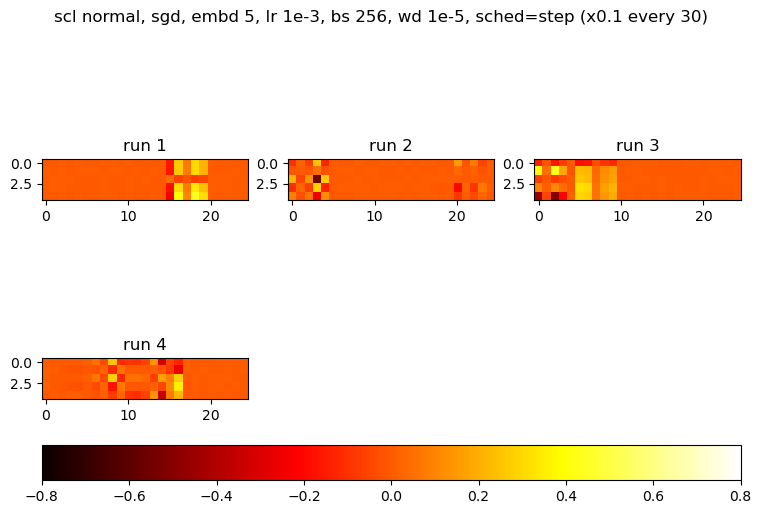

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


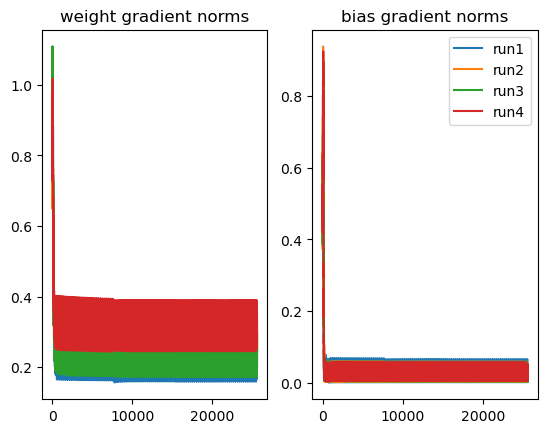

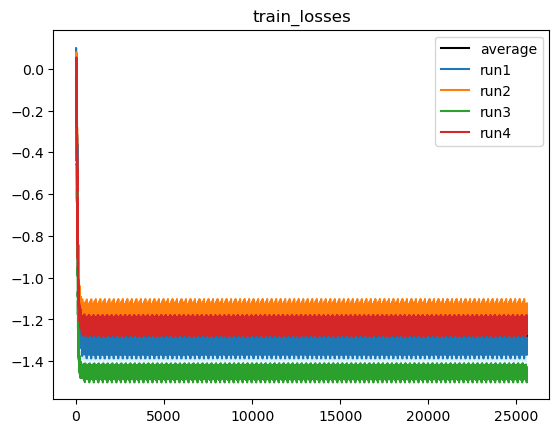

array([[0.4867    , 0.50480002, 0.50340003, 0.99690002, 0.49939999],
       [0.9932    , 0.49919999, 0.49599999, 0.50370002, 0.98460001],
       [0.99620003, 0.99580002, 0.4982    , 0.49900001, 0.50050002],
       [0.82050002, 0.99239999, 0.99159998, 0.9928    , 0.50269997]])

In [6]:
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 5, lr 1e-3, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

In [11]:
testdir = './outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run1'
run_dict = torch.load(os.path.join(testdir, 'run_dict'))
run_dict['args']

Namespace(alg='spectral', backbone='linear', optim='sgd', emb_dim=5, n=65536, aug='normal', epochs=100, bs=256, lr=0.0003, wd=1e-05, sched='step', save_dir='./outputs/normal_hparam_tuning2', num_feats=5, feat_dim=5, sgd_momentum=0.9)

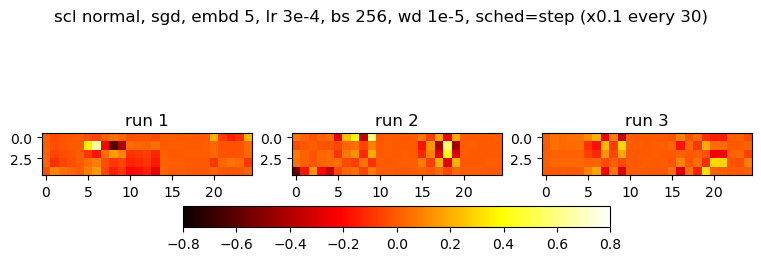

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


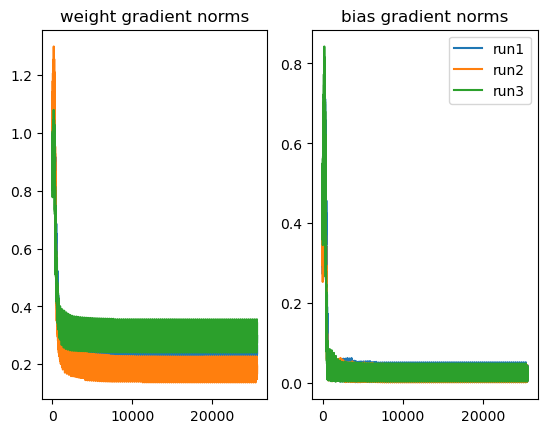

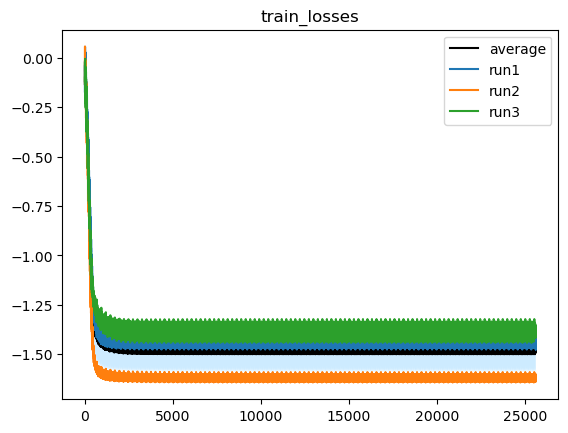

array([[0.9727    , 0.991     , 0.9921    , 0.50010002, 0.98900002],
       [0.99489999, 0.99680001, 0.4966    , 0.99779999, 0.50650001],
       [0.96969998, 0.99169999, 0.50629997, 0.99190003, 0.99330002]])

In [8]:
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run3',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 5, lr 3e-4, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

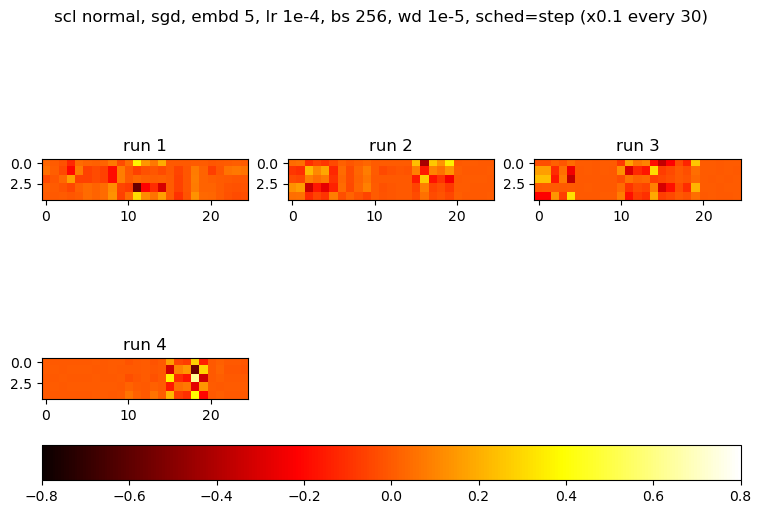

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


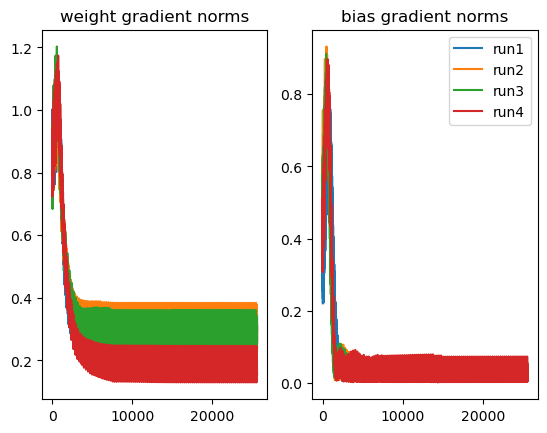

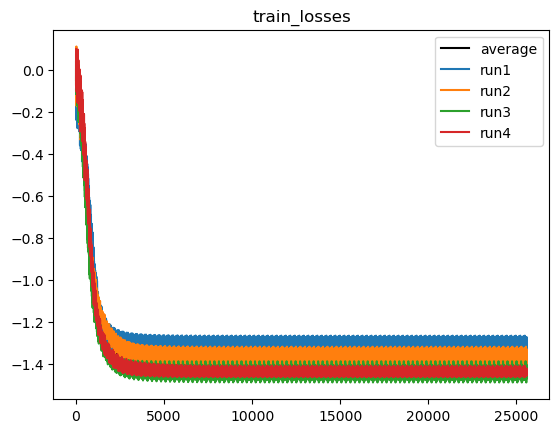

array([[0.89850003, 0.92110002, 0.99070001, 0.9623    , 0.6318    ],
       [0.99180001, 0.95850003, 0.64780003, 0.99119997, 0.51419997],
       [0.99309999, 0.52179998, 0.99589998, 0.99489999, 0.51109999],
       [0.49450001, 0.50230002, 0.92580003, 0.99659997, 0.58700001]])

In [9]:
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=5_aug=normal_lr=0.0001_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 5, lr 1e-4, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr


### SCL: embed_dim > 5

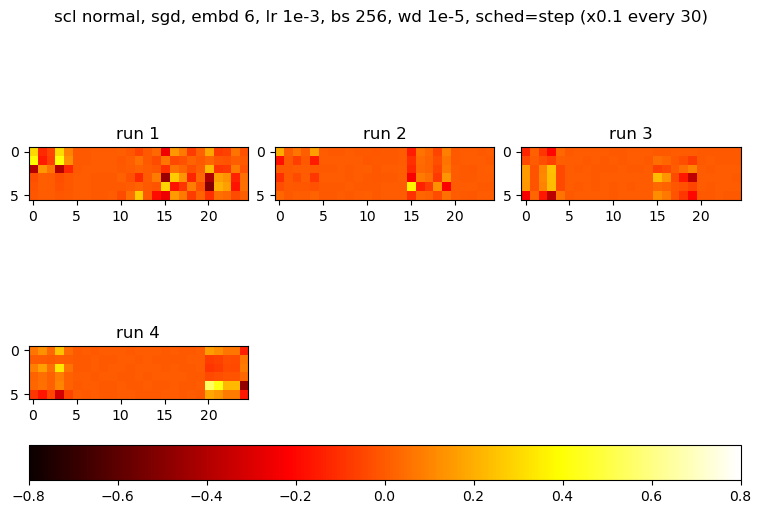

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


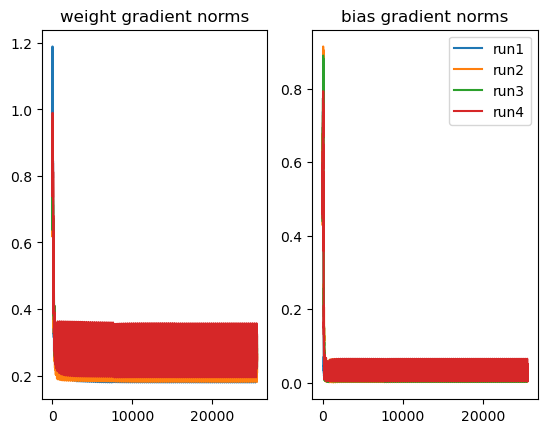

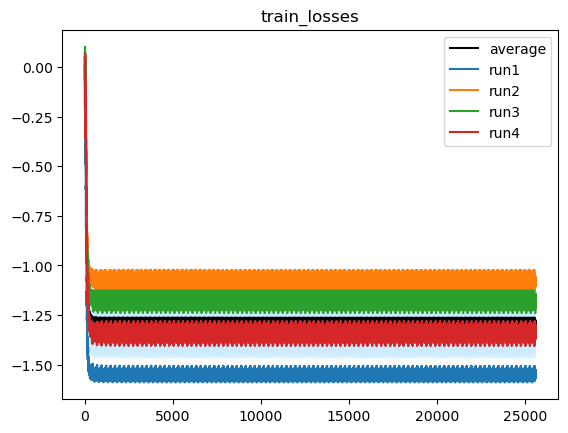

array([[0.9971    , 0.4955    , 0.99260002, 0.99349999, 0.99119997],
       [0.98830003, 0.50760001, 0.51599997, 0.98940003, 0.49759999],
       [0.99309999, 0.50190002, 0.49399999, 0.9896    , 0.50520003],
       [0.9939    , 0.50139999, 0.50419998, 0.50080001, 0.99599999]])

In [5]:
# embd = 6
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=6_aug=normal_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=6_aug=normal_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=6_aug=normal_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=6_aug=normal_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 6, lr 1e-3, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

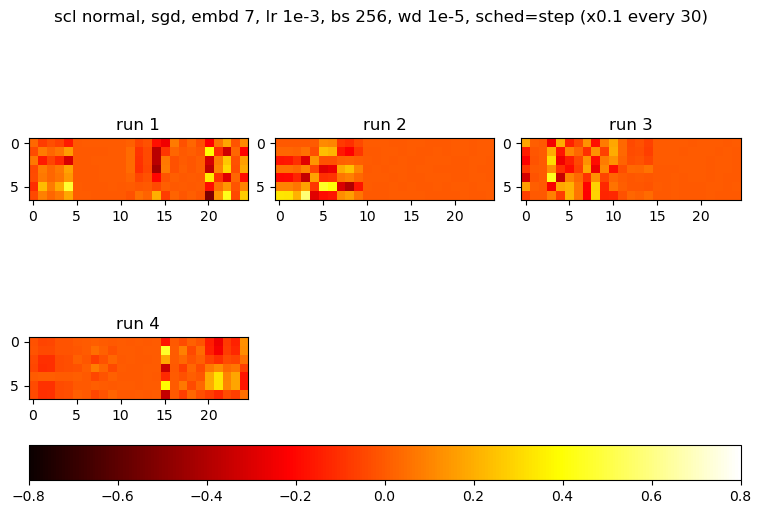

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


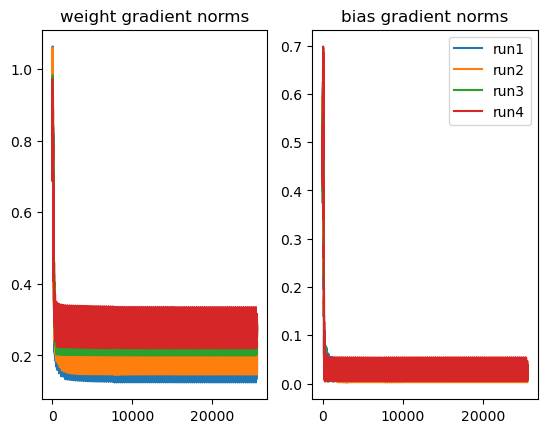

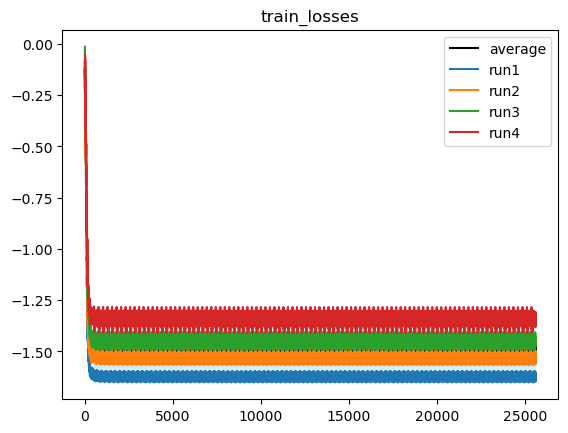

array([[0.9928    , 0.50300002, 0.99409997, 0.98860002, 0.99580002],
       [0.99599999, 0.99599999, 0.4921    , 0.5       , 0.4966    ],
       [0.99419999, 0.99400002, 0.99339998, 0.51429999, 0.50309998],
       [0.9831    , 0.96569997, 0.51770002, 0.99269998, 0.99180001]])

In [6]:
# embd = 7
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=7_aug=normal_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=7_aug=normal_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=7_aug=normal_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=7_aug=normal_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 7, lr 1e-3, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

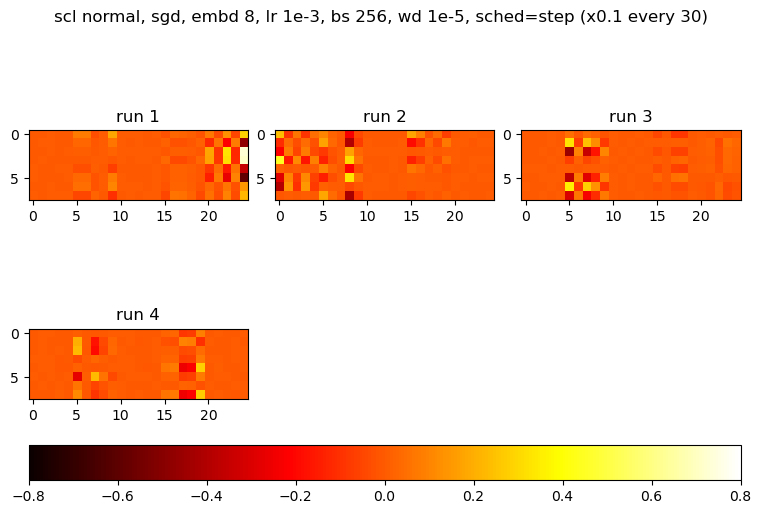

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


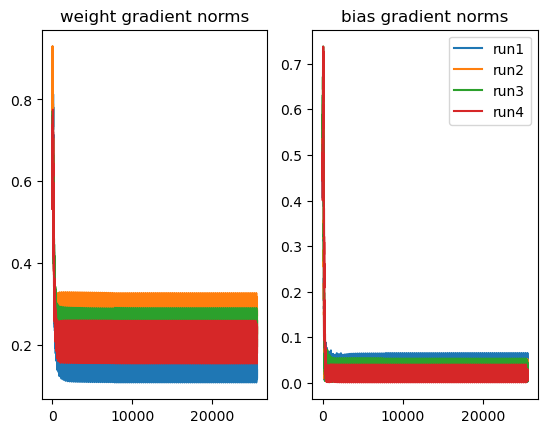

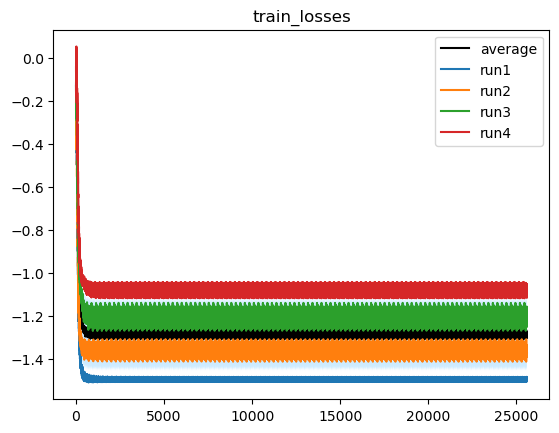

array([[0.5029    , 0.98500001, 0.4928    , 0.97549999, 0.9989    ],
       [0.995     , 0.9946    , 0.50580001, 0.98710001, 0.4975    ],
       [0.50089997, 0.99470001, 0.49939999, 0.96219999, 0.96429998],
       [0.50190002, 0.98769999, 0.4991    , 0.98720002, 0.50840002]])

In [7]:
# embd = 8
dirs = [
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=8_aug=normal_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=8_aug=normal_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=8_aug=normal_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/spectral_linear_sgd_emb_dim=8_aug=normal_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='scl normal, sgd, embd 8, lr 1e-3, bs 256, wd 1e-5, sched=step (x0.1 every 30)')
plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
plot_metrics(dirs, plotall=True)
score_arr

### MSSL Hyperparam Tuning

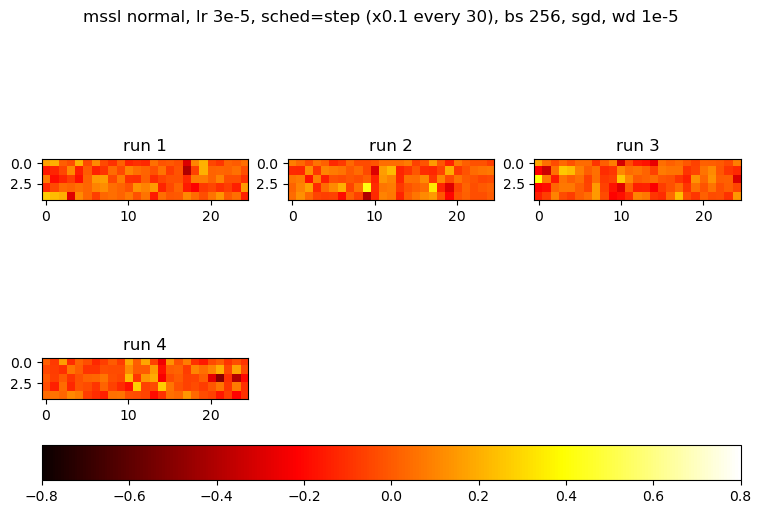

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


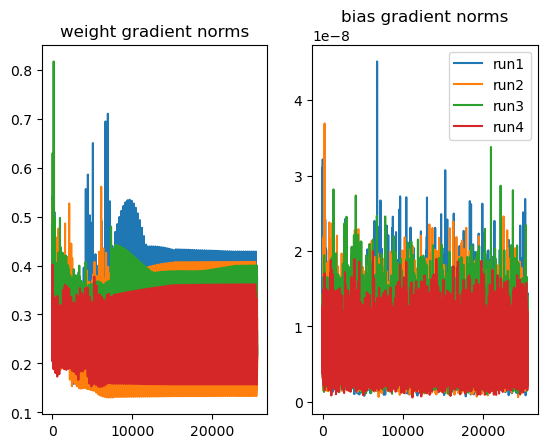

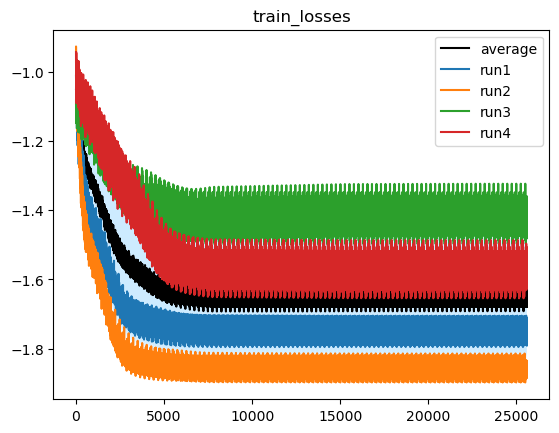

array([[0.94709998, 0.52130002, 0.66250002, 0.94660002, 0.54369998],
       [0.70880002, 0.95120001, 0.9285    , 0.86089998, 0.5679    ],
       [0.92580003, 0.77509999, 0.94760001, 0.68419999, 0.69230002],
       [0.54030001, 0.53869998, 0.94660002, 0.5898    , 0.94050002]])

In [12]:
# mssl lr = 3e-4 sgd wd 1e-5 sched step (x0.1 ever 30 epochs), bs 256
dirs = [
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run1',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run2',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run3',
'./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=5_aug=normal_lr=0.0003_sched=step_run4',
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, lr 3e-5, sched=step (x0.1 every 30), bs 256, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

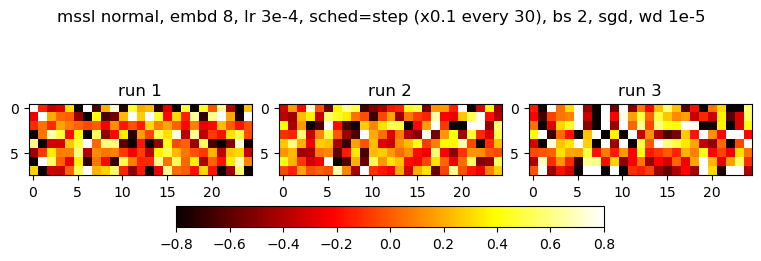

array([[0.76310003, 0.67989999, 0.69410002, 0.72539997, 0.64429998],
       [0.76630002, 0.77950001, 0.65359998, 0.74000001, 0.76020002],
       [0.63840002, 0.71869999, 0.71429998, 0.68089998, 0.67210001]])

In [19]:
# mssl lr = 3e-4 sgd wd 1e-5 sched step (x0.1 ever 30 epochs), bs 2, embd= 8 for some reason
dirs = [
"./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=8_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=8_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning2/normal/mssla_linear_sgd_emb_dim=8_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run3"
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 8, lr 3e-4, sched=step (x0.1 every 30), bs 2, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

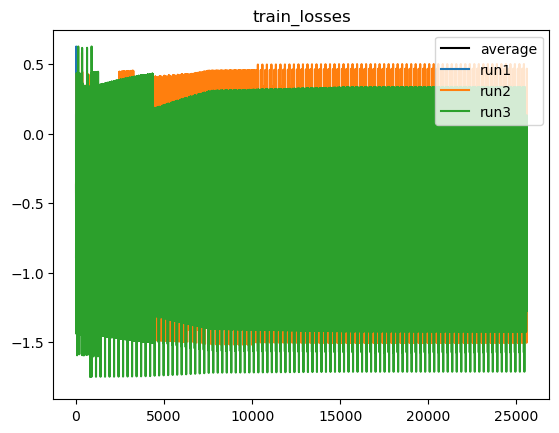

In [16]:
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# relatively bad loss because of small batch size...
plot_metrics(dirs, plotall=True)

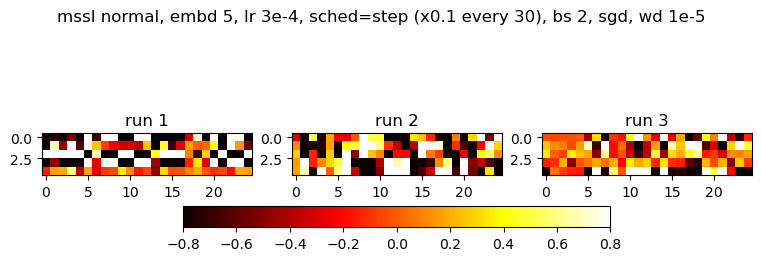

array([[0.63840002, 0.58810002, 0.57300001, 0.5632    , 0.58670002],
       [0.59939998, 0.62400001, 0.60479999, 0.6437    , 0.57410002],
       [0.5492    , 0.63980001, 0.66079998, 0.66460001, 0.66850001]])

In [17]:
# mssl lr = 3e-4 sgd wd 1e-5 sched step (x0.1 ever 30 epochs), bs 2, embd=5
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=512_aug=normal_bs=2_lr=0.0003_sched=step_run3",
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 3e-4, sched=step (x0.1 every 30), bs 2, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

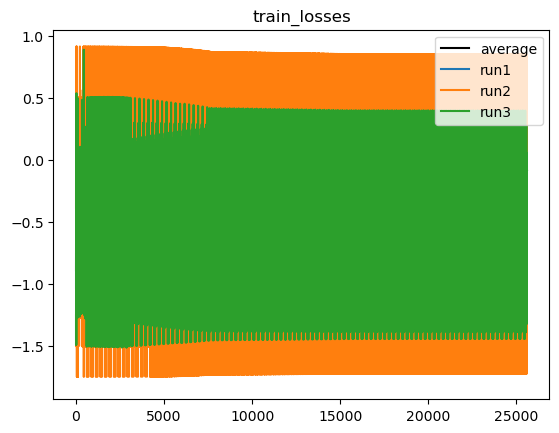

In [18]:
plot_metrics(dirs, plotall=True)

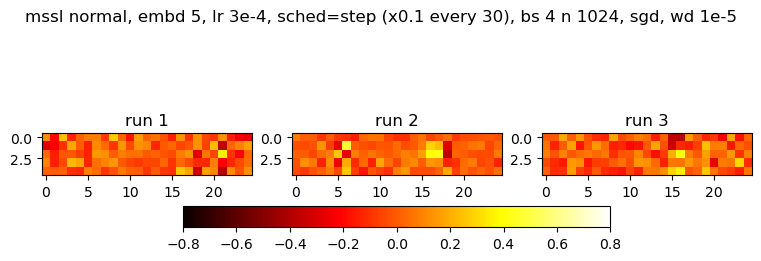

array([[0.71069998, 0.6886    , 0.55729997, 0.83310002, 0.889     ],
       [0.60229999, 0.92640001, 0.68199998, 0.9321    , 0.59899998],
       [0.56599998, 0.6584    , 0.65100002, 0.91210002, 0.59210002]])

In [20]:
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0003_sched=step_run3",
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 3e-4, sched=step (x0.1 every 30), bs 4 n 1024, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

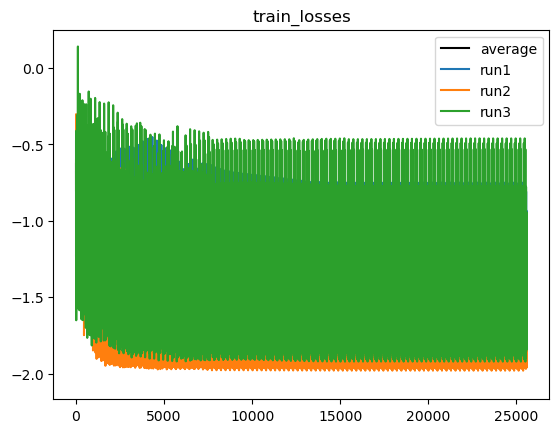

In [21]:
plot_metrics(dirs, plotall=True)

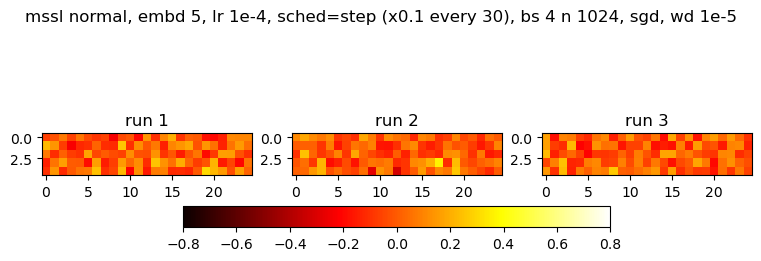

array([[0.58590001, 0.57300001, 0.6225    , 0.61720002, 0.6365    ],
       [0.65820003, 0.75199997, 0.70550001, 0.76179999, 0.56239998],
       [0.6631    , 0.71619999, 0.65990001, 0.5873    , 0.6074    ]])

In [22]:
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0001_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0001_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=1024_aug=normal_bs=4_lr=0.0001_sched=step_run3"
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 1e-4, sched=step (x0.1 every 30), bs 4 n 1024, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

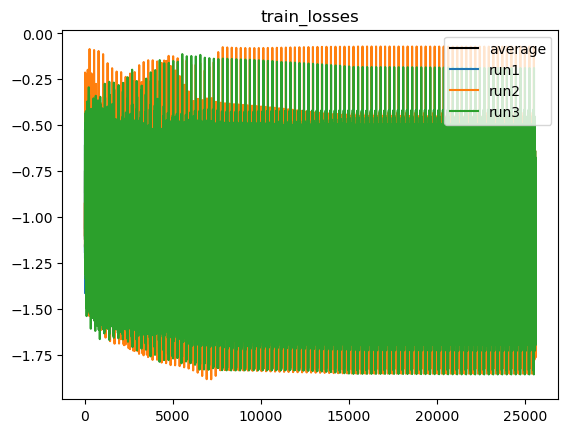

In [23]:
plot_metrics(dirs, plotall=True)

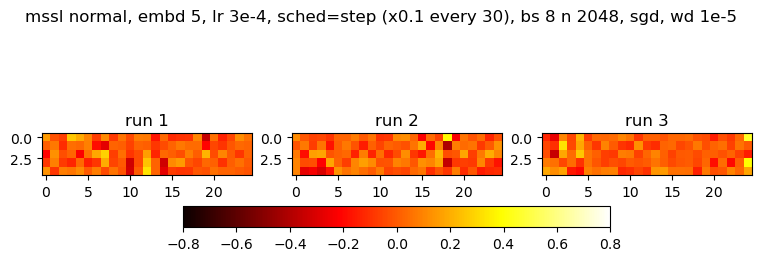

array([[0.78079998, 0.87840003, 0.92189997, 0.7256    , 0.51529998],
       [0.80419999, 0.62489998, 0.58359998, 0.95050001, 0.69940001],
       [0.95240003, 0.56889999, 0.65060002, 0.52609998, 0.95349997]])

In [24]:
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=2048_aug=normal_bs=8_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=2048_aug=normal_bs=8_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=2048_aug=normal_bs=8_lr=0.0003_sched=step_run3"
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 3e-4, sched=step (x0.1 every 30), bs 8 n 2048, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

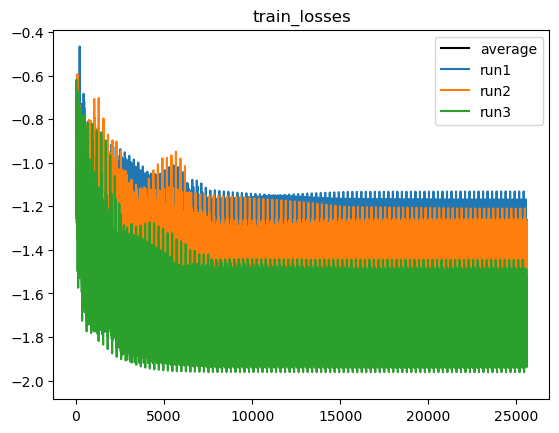

In [25]:
plot_metrics(dirs, plotall=True)

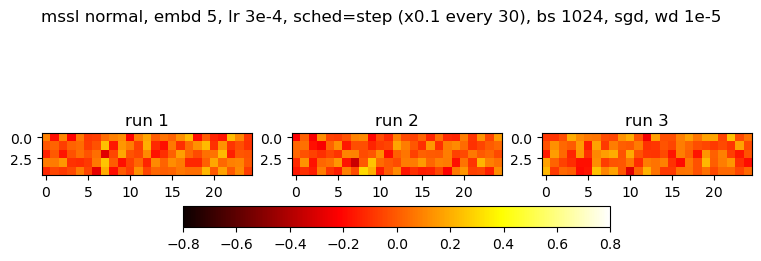

array([[0.62620002, 0.82620001, 0.55250001, 0.66460001, 0.7033    ],
       [0.7464    , 0.90890002, 0.72909999, 0.67909998, 0.54839998],
       [0.74949998, 0.80129999, 0.76789999, 0.71710002, 0.66769999]])

In [6]:
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_aug=normal_bs=1024_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_aug=normal_bs=1024_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_aug=normal_bs=1024_lr=0.0003_sched=step_run3",
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 3e-4, sched=step (x0.1 every 30), bs 1024, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

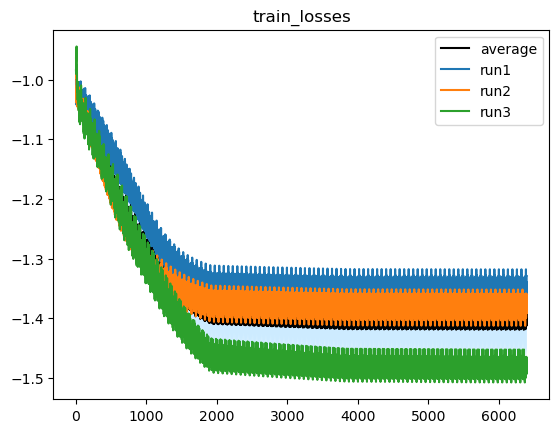

In [7]:
plot_metrics(dirs, plotall=True)

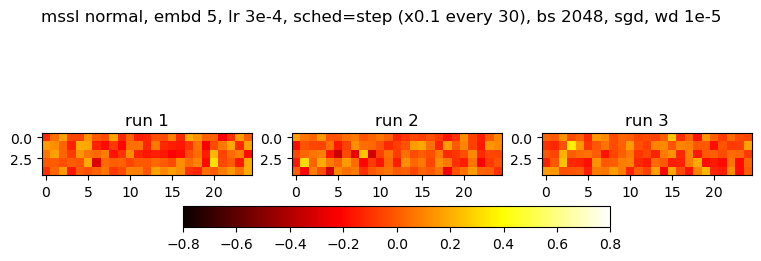

array([[0.59619999, 0.68760002, 0.61449999, 0.66159999, 0.76609999],
       [0.82169998, 0.96319997, 0.61629999, 0.62019998, 0.65509999],
       [0.7507    , 0.8265    , 0.62540001, 0.86290002, 0.55580002]])

In [6]:
dirs = [
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=131072_aug=normal_bs=2048_lr=0.0003_sched=step_run1",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=131072_aug=normal_bs=2048_lr=0.0003_sched=step_run2",
"./outputs/normal_hparam_tuning3/normal/mssla_linear_sgd_emb_dim=5_n=131072_aug=normal_bs=2048_lr=0.0003_sched=step_run3",
]
score_arr = get_feature_downstream_scores(dirs)
clear_output()
show_weights(dirs, plot_weights=True, subtitle=True, title='mssl normal, embd 5, lr 3e-4, sched=step (x0.1 every 30), bs 2048, sgd, wd 1e-5')
# plot_metrics(dirs, toplot='gradient_norms', aggregate=False, plotall=True)
# plot_metrics(dirs, plotall=True)
score_arr

In [ ]:
plot_metrics(dirs, plotall=True)